In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
bond_pmts = pd.read_pickle("../../data/mbs_data_pickled/bond_pmts.pkl")

# Import credit ratings data and add it to the month-by-month dataframe
credit_ratings = pd.read_pickle("../../data/mbs_data_pickled/credit_ratings.pkl")
credit_ratings.drop(labels=['I-CE','I-P','II-CE','II-P'],level=1,inplace=True)
credit_ratings.drop(columns=['CUSIP'],inplace=True)
returns_with_ratings = pd.concat([credit_ratings,bond_pmts],axis=1)

# Add columns with numerical versions of Moody's ratings, with a higher number being better (Aaa = 21, C = 1)
moodys_to_numbers = {'Aaa':21,'Aa1':20,'Aa2':19,'Aa3':18,'A1':17,'A2':16,'A3':15,'Baa1':14,'Baa2':13,'Baa3':12,'Ba1':11,'Ba2':10,'Ba3':9,'B1':8,'B2':7,'B3':6,'Caa1':5,'Caa2':4,'Caa3':3,'Ca':2,'C':1,'WR':1}
returns_with_ratings['Moody\'s Numerical'] = returns_with_ratings['Moody\'s'].str.strip().map(moodys_to_numbers)

# Change the order of the columns so the credit ratings are all the way on the right
cols = returns_with_ratings.columns.tolist()
cols.append("Moody\'s")
cols.append("S&P")
cols = cols[2:]
cols
returns_with_ratings = returns_with_ratings[cols]

In [3]:
# Function which sets right y-axis label to letter-based credit ratings and not numbers
def ratings_on_right_y_axis(axes,stepsize):
    """ Sets the labels of the right y-axis to proper letter-based credit ratings.
        axes: matplotlib axes object
        stepsize: the desired jump between ratings on the y-axis
    """
    # Step 1: make sure only integer values are used on the y-axis
    # (so they'll correspond to actual ratings)
    orig_y_labels = axes.get_yticks().tolist()
    minimum_rating = round(orig_y_labels[0],0)
    if minimum_rating == 0:
        minimum_rating = 1
    maximum_rating = round(orig_y_labels[-1],0)
    if maximum_rating > 21:
        maximum_rating = 21
    ratings_labels = np.arange(minimum_rating,maximum_rating,step=stepsize)
    axes.set_yticks(ratings_labels)
    new_y_labels = axes.get_yticks().tolist()

    # Step 2: convert all numeric values on the y-axis to letter-based credit ratings
    numbers_to_moodys = {y:x for x,y in moodys_to_numbers.items()}
    for i in range(len(new_y_labels)):
        if new_y_labels[i] <= 21 and new_y_labels[i] >= 1:
            new_y_labels[i] = numbers_to_moodys[new_y_labels[i]]
    axes.set_yticklabels(new_y_labels)

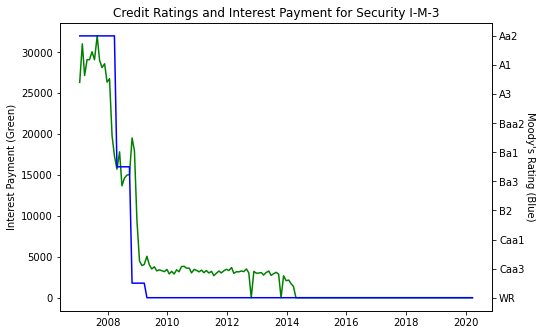

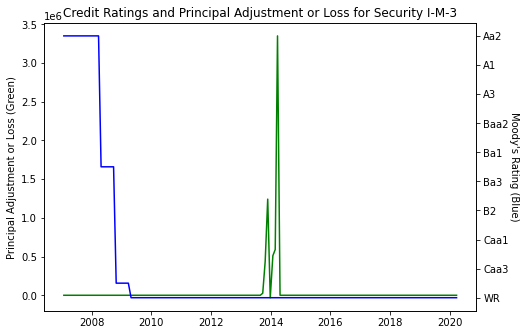

In [4]:
def plot_ratings(security, comparison_series, stepsize=1,begin_date='2007-01-01',end_date='2020-03-31'):
    the_plot = plt.figure()
    ratings_data = returns_with_ratings['Moody\'s Numerical'].xs(security,level=1).loc[begin_date:end_date]
    comparison_data = returns_with_ratings[comparison_series].xs(security,level=1).loc[begin_date:end_date]
    left_axes = the_plot.add_axes([0,0,1,1])
    right_axes = left_axes.twinx()
    right_axes.plot(ratings_data,color='blue')

    ratings_on_right_y_axis(right_axes,stepsize)

    right_axes.set_ylabel('Moody\'s Rating' + ' (Blue)',rotation=270)
    right_axes.yaxis.set_label_coords(1.1,0.5)
    left_axes.plot(comparison_data,color='green')
    left_axes.set_ylabel(comparison_data.name + " (Green)")
    left_axes.set_title("Credit Ratings and " + comparison_series + " for Security " + security)

plot_ratings("I-M-3","Interest Payment", 2, "2007-01-01","2020-03-31")
plot_ratings("I-M-3","Principal Adjustment or Loss", 2, "2007-01-01","2020-03-31")

## Theories from 5/16/2020 work (pertaining to Group I only, for now)
1. Even though the mezzanine securities suffer principal losses sequentially, they were all downgraded to near-C levels at roughly the same time -- this seems to indicate Moody's properly identified that a huge chunk of them were going to lose money at some point in the future?
2. As seniority INCREASES, ratings downgrades go from a leading to a lagging indicator of changes in interest payments -- so, lower-rated securities were downgraded more quickly as Moody's started to understand the MBS market better, but they gave senior securities the "benefit of the doubt" for a while even though they were suffering lower interest payments?

NEXT TASK:
Investigate how much of the fall in interest payments was due to lower adjustable rates, and how much was not (e.g. how much of the fall in mortgage interest PAYMENTS by homeowners can be viewed as a leading indicator of defaults, and how much was just a function of falling interest RATES on the underlying mortgages)
- Potential strategy: Compare MORTGAGE INTEREST PAYMENTS (where to find this in investor rpt??) to MORTGAGE INTEREST RATES and find the correlation -- would describe "what percent of the variation in interest payments is due to the variation in adjustable rates"
- Or, just use the fixed-rate mortgages? Don't know how to separate those out yet

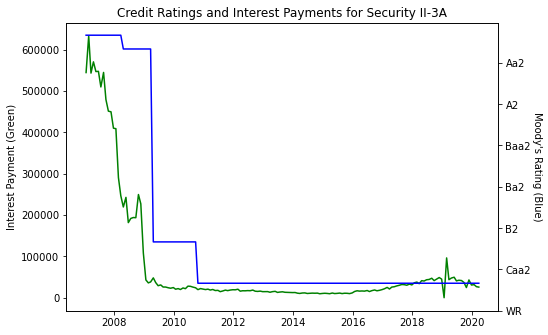

In [5]:
# ALTERNATE [NON-FUNCTION-BASED] SYSTEM FOR PLOTTING CREDIT RATINGS ALONG WITH OTHER SERIES

the_plot = plt.figure()
# PARAMETERS:
security = 'II-3A'
begin_date='2007-01-01'
end_date='2020-03-31'
stepsize = 3
ratings_data = returns_with_ratings['Moody\'s Numerical'].xs(security,level=1).loc[begin_date:end_date]
left_axes = the_plot.add_axes([0,0,1,1])
right_axes = left_axes.twinx()
right_axes.plot(ratings_data,color='blue')

ratings_on_right_y_axis(right_axes,stepsize)

right_axes.set_ylabel('Moody\'s Rating' + ' (Blue)',rotation=270)
right_axes.yaxis.set_label_coords(1.1,0.5)
left_axes.plot(returns_with_ratings.xs(security,level=1)['Interest Payment'].loc[begin_date:end_date],color='green')
# left_axes.set_ylabel('comparison_data.name + " (Green)"')
left_axes.set_ylabel('Interest Payment (Green)')
left_axes.set_title("Credit Ratings and Interest Payments for Security " + security)
plt.show()

<ipython-input-6-874d119de0fb>:26: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  general_axes_separate.axvline(pd.datetime(2008,3,16),lw=1,color='black')
<ipython-input-6-874d119de0fb>:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ratings_axes_separate.axvline(pd.datetime(2008,3,16),lw=1,color='black')


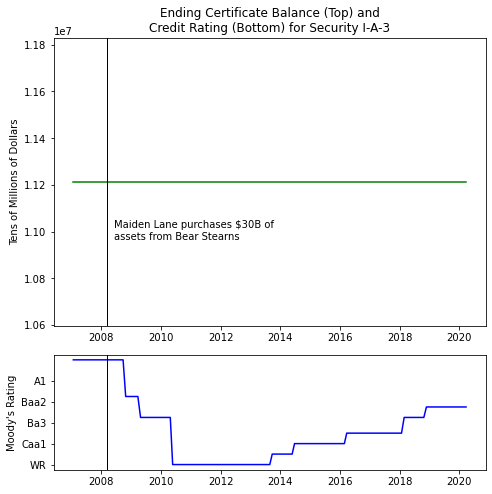

In [6]:
# HERE, WE SEPARATE THE GRAPHS! [TO MAKE CLEAR THAT THERE'S NO CARDINAL COMPARISON BETWEEN CREDIT RATING AND DOLLAR-DENOMINATED FIELDS]
# ALTERNATE [NON-FUNCTION-BASED] SYSTEM FOR PLOTTING CREDIT RATINGS ALONG WITH OTHER SERIES

the_plot_separate = plt.figure()
# PARAMETERS:
security = 'I-A-3'
field = 'Ending Certificate Balance'
begin_date='2007-01-01'
end_date='2020-03-31'
stepsize = 4

ratings_data = returns_with_ratings['Moody\'s Numerical'].xs(security,level=1).loc[begin_date:end_date]
general_axes_separate = the_plot_separate.add_axes([0,0.5,1,1])

ratings_axes_separate = the_plot_separate.add_axes([0,0,1,0.4])
ratings_axes_separate.plot(ratings_data,color='blue')
ratings_on_right_y_axis(ratings_axes_separate,stepsize)

ratings_axes_separate.set_ylabel('Moody\'s Rating')
general_axes_separate.plot(returns_with_ratings.xs(security,level=1)[field].loc[begin_date:end_date],color='green')

general_axes_separate.set_ylabel(field)
general_axes_separate.set_title(field + " (Top) and\nCredit Rating (Bottom) for Security " + security)
general_axes_separate.set_ylabel('Tens of Millions of Dollars')

general_axes_separate.axvline(pd.datetime(2008,3,16),lw=1,color='black')
ratings_axes_separate.axvline(pd.datetime(2008,3,16),lw=1,color='black')
the_plot_separate.text(0.14,0.8,'Maiden Lane purchases $30B of\nassets from Bear Stearns')
the_plot_separate.savefig('../../figures/timeseries_maiden_lane_ia3.png',dpi=200,bbox_inches='tight')

<ipython-input-7-1e6ffe19f77c>:26: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  general_axes_separate.axvline(pd.datetime(2008,3,16),lw=1,color='black')
<ipython-input-7-1e6ffe19f77c>:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ratings_axes_separate.axvline(pd.datetime(2008,3,16),lw=1,color='black')


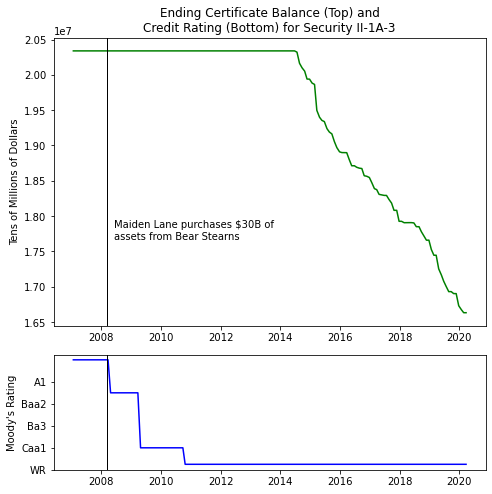

In [7]:
# HERE, WE SEPARATE THE GRAPHS! [TO MAKE CLEAR THAT THERE'S NO CARDINAL COMPARISON BETWEEN CREDIT RATING AND DOLLAR-DENOMINATED FIELDS]
# ALTERNATE [NON-FUNCTION-BASED] SYSTEM FOR PLOTTING CREDIT RATINGS ALONG WITH OTHER SERIES

the_plot_separate = plt.figure()
# PARAMETERS:
security = 'II-1A-3'
field = 'Ending Certificate Balance'
begin_date='2007-01-01'
end_date='2020-03-31'
stepsize = 4

ratings_data = returns_with_ratings['Moody\'s Numerical'].xs(security,level=1).loc[begin_date:end_date]
general_axes_separate = the_plot_separate.add_axes([0,0.5,1,1])

ratings_axes_separate = the_plot_separate.add_axes([0,0,1,0.4])
ratings_axes_separate.plot(ratings_data,color='blue')
ratings_on_right_y_axis(ratings_axes_separate,stepsize)

ratings_axes_separate.set_ylabel('Moody\'s Rating')
general_axes_separate.plot(returns_with_ratings.xs(security,level=1)[field].loc[begin_date:end_date],color='green')

general_axes_separate.set_ylabel(field)
general_axes_separate.set_title(field + " (Top) and\nCredit Rating (Bottom) for Security " + security)
general_axes_separate.set_ylabel('Tens of Millions of Dollars')

general_axes_separate.axvline(pd.datetime(2008,3,16),lw=1,color='black')
ratings_axes_separate.axvline(pd.datetime(2008,3,16),lw=1,color='black')
the_plot_separate.text(0.14,0.8,'Maiden Lane purchases $30B of\nassets from Bear Stearns')
the_plot_separate.savefig('../../figures/timeseries_maiden_lane_ii1a3.png',dpi=200,bbox_inches='tight')

In [8]:
returns_with_ratings.xs('II-1A-3',level=1)['Moody\'s'].loc['2008-01-01':'2012-01-01']

Date
2008-01-25     Aaa
2008-02-25     Aaa
2008-03-25     Aaa
2008-04-25      A3
2008-05-27      A3
2008-06-25      A3
2008-07-25      A3
2008-08-25      A3
2008-09-25      A3
2008-10-27      A3
2008-11-25      A3
2008-12-26      A3
2009-01-26      A3
2009-02-25      A3
2009-03-25      A3
2009-04-27    Caa1
2009-05-26    Caa1
2009-06-25    Caa1
2009-07-27    Caa1
2009-08-25    Caa1
2009-09-25    Caa1
2009-10-26    Caa1
2009-11-25    Caa1
2009-12-28    Caa1
2010-01-25    Caa1
2010-02-25    Caa1
2010-03-25    Caa1
2010-04-26    Caa1
2010-05-25    Caa1
2010-06-25    Caa1
2010-07-26    Caa1
2010-08-25    Caa1
2010-09-27    Caa1
2010-10-25      Ca
2010-11-26      Ca
2010-12-27      Ca
2011-01-25      Ca
2011-02-25      Ca
2011-03-25      Ca
2011-04-25      Ca
2011-05-25      Ca
2011-06-27      Ca
2011-07-25      Ca
2011-08-25      Ca
2011-09-26      Ca
2011-10-25      Ca
2011-11-25      Ca
2011-12-27      Ca
Name: Moody's, dtype: object